# Anomaly Detection Models

This function extracts the features specified in the array from the json file provided to it and stores it in a csv file at the location provided to it. 

Edit the file locations (source json; destination csv) and run the code to generate the requisite datasets.

In [17]:
import json, csv, sys, datetime

with open('../dataset/sample_first_50000.json', 'r') as file:
	i = 0
	j = 0
	# TODO: change list-based stuff to dict
	data = {}
	ipList = []
	# iterate over each logged line
	for line in file:
		newItem = {}
		try:
			jsonData = json.loads(line)
		except:
			print "\nLine {0} is not in JSON format".format(i)
			i += 1
			j += 1
			continue

		if 'data' in jsonData:
			timestamp = str(jsonData['data']['event_timestamp'])
			hour_of_the_day = (float(timestamp[11:13]) + float(timestamp[14:16])/60 + float(timestamp[17:19])/3600)
			# 0 - Monday; 6 - Sunday
			day_of_the_week = datetime.datetime(int(timestamp[:4]), \
				int(timestamp[5:7]), int(timestamp[8:10]), int(timestamp[11:13]), \
				int(timestamp[14:16]), int(timestamp[17:19])).weekday()
			newItem["hour_of_the_day"] = hour_of_the_day
			newItem["day_of_the_week"] = day_of_the_week
		
			featuresFromData = ["client_user", "client_host", "client_ip", "client_program", "CONNECT_DATA_INSTANCE_NAME", "service_name"]
			for feature in featuresFromData:
				if feature in jsonData['data']:
					newItem[feature] = str(jsonData['data'][feature])
				else:
					newItem[feature] = ""

		if 'metadata' in jsonData:
			featuresFromMetadata = ["oracle_sid", "hostname"]
			for feature in featuresFromMetadata:
				if feature in jsonData['metadata']:
					newItem[feature] = str(jsonData['metadata'][feature])
				else:
					newItem[feature] = ""

		# ignore cases where data is incomplete/very little to analyse
		if len(newItem) <= 2:
			continue

		else:
			data[i] = newItem
			ipList.append(newItem["client_ip"])
		# increment item number within the data
		i += 1

if j > 0:
	print "Could not store {0} lines due to invalid format".format(j)

fieldNames = ['hour_of_the_day', 'day_of_the_week', 'client_user', 'client_host', 'client_ip', 'client_program', 'CONNECT_DATA_INSTANCE_NAME', 'service_name', 'oracle_sid', 'hostname']

with open('../dataset/preprocessed_first_50000.csv', 'w') as csvFile:
	writer = csv.DictWriter(csvFile, fieldnames=fieldNames)
	writer.writeheader()
	
	for item in data:
		writer.writerow(data[item])
print"Data written to file."

Data written to file.


In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer

#Read in the data and store it in a dataframe
data = pd.read_csv('../dataset/preprocessed_first_50000.csv').fillna('0')
data = data.to_dict(orient='records')

#DictVectorizer allows us to transform categorical data into numerical format
vec = DictVectorizer()
X = np.array(vec.fit_transform(data).toarray())

#Robust Scaling works better for large sparse matrices (?)
X = preprocessing.robust_scale(X)
print "\nDimensions of feature matrix: ", X.shape
np.savetxt('../dataset/matX.txt', X)

#TruncatedSVD works better than PCA for our use-case
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)

#Outcome of PCA similar to SVD, just to verify
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)




Dimensions of feature matrix:  (50000, 588)

Modified dimensions of feature matrix:  (50000, 2)


Visualisation of the data

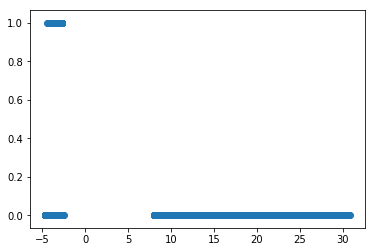

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(X_pca[:, 0], X[:, 1])


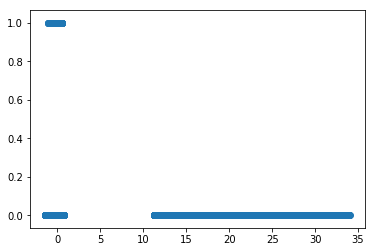

In [20]:
plt.scatter(X_svd[:, 0], X[:, 1])

The following code attempts to perform K-Means Clustering on the data.

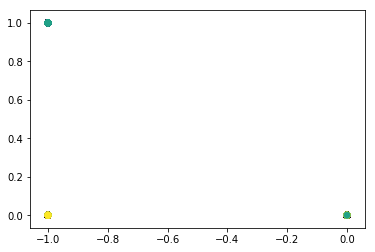

In [25]:
from sklearn import cluster

k_means = cluster.KMeans(15)
k_means.fit(X_svd)
plt.scatter(X[:,0],X[:,1],c=k_means.labels_)

Let us now fit a KNN based model to our data

In [ ]:
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
